# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# File path

In [2]:
dataPath = "D:\data\Soccernet"
imgPath = "res"

# Load all the labels

In [3]:
def loadFile():
    table = []
    for m in os.listdir(dataPath):
        match = os.path.join(dataPath, m)
        for y in os.listdir(match):
            year = os.path.join(match, y)
            for l in os.listdir(year):
                league = os.path.join(year, l)
                fileName = os.path.join(league, 'Labels-v2.json')
                if (not(os.path.exists(fileName))):
                    continue

                file = open(fileName, 'r')
                jsonData = json.load(file)
                
                # json.dumps(jsonData, indent = 4)
                videoName = jsonData['UrlLocal']
                events = jsonData['annotations']
                for e in events:
                    half = int(e['gameTime'][0])
                    eventTime = e['gameTime'][-4:]
                    label = e['label']
                    ms = int(e['position'])
                    team = e['team']
                    visibility = e['visibility']
                    table.append([videoName, half, eventTime, ms, label, team, visibility])
    return table

In [4]:
df = pd.DataFrame(loadFile(), columns=[
    'name', 
    'half', 
    'time', 
    'milisecond',
    'label', 
    'team', 
    'visibility'
])
df.head()

,name,half,time,milisecond,label,team,visibility
0,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,0:00,0,Kick-off,away,visible
1,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,2:13,133295,Ball out of play,not applicable,visible
2,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,2:29,149168,Throw-in,away,visible
3,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,2:36,156098,Ball out of play,not applicable,visible
4,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,3:02,182775,Corner,away,visible


# Exploration data analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110458 entries, 0 to 110457
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   name        110458 non-null  object
 1   half        110458 non-null  int64 
 2   time        110458 non-null  object
 3   milisecond  110458 non-null  int64 
 4   label       110458 non-null  object
 5   team        110458 non-null  object
 6   visibility  110458 non-null  object
dtypes: int64(2), object(5)
memory usage: 5.9+ MB


In [6]:
df.describe()

,half,milisecond
count,110458.000000,1.104580e+05
mean,1.517400,1.367662e+06
std,0.499699,8.073690e+05
min,1.000000,0.000000e+00
25%,1.000000,6.647682e+05
50%,2.000000,1.363914e+06
75%,2.000000,2.067294e+06
max,2.000000,3.231909e+06


# Class distribution

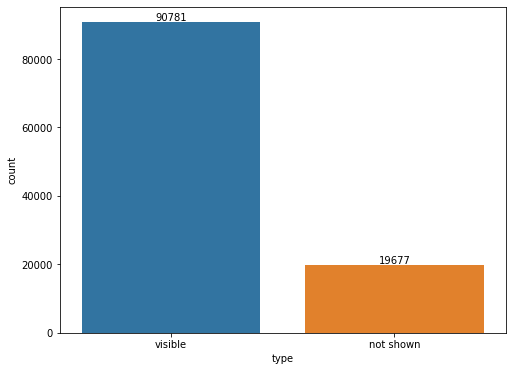

In [7]:
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=df['visibility'].value_counts().reset_index(0),
    x='index',
    y='visibility'
)
ax.bar_label(ax.containers[0])
ax.set_xlabel('type')
ax.set_ylabel('count')
plt.savefig(os.path.join(imgPath, "visible_distribution.png"))
plt.show()

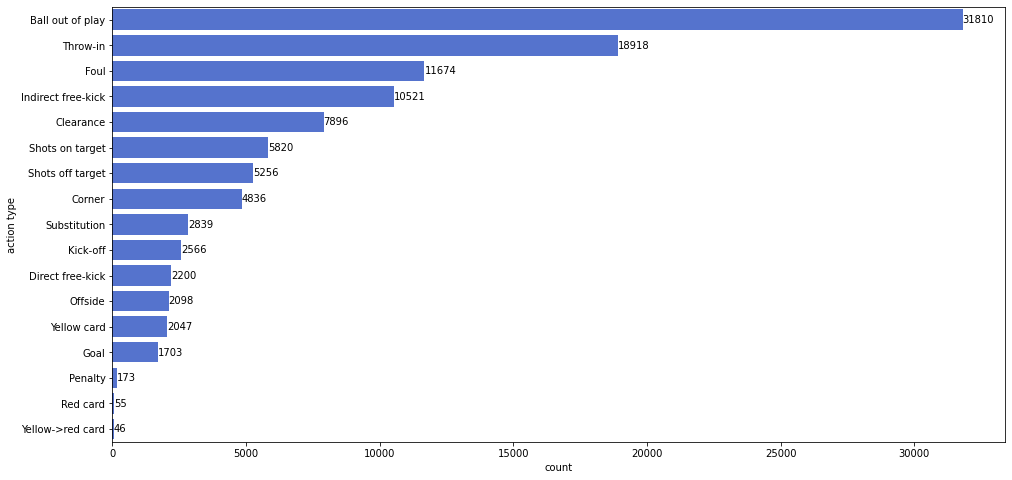

In [8]:
plt.figure(figsize=(16,8))
ax = sns.barplot(
    data=df['label'].value_counts().reset_index(0),
    x='label',
    y='index',
    color='royalblue'
)
ax.bar_label(ax.containers[0])
ax.set_xlabel('count')
ax.set_ylabel('action type')
plt.savefig(os.path.join(imgPath, "class_distribution.png"))
plt.show()

In [9]:
def test(df):
    prev = [np.nan]+df['label'].to_list()[:-1]
    df['prev'] = prev
    df['milisecond'] = df['milisecond'].diff()
    return df

differences = df.groupby(by=['name','half']).apply(test)
differences.head()

,name,half,time,milisecond,label,team,visibility,prev
0,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,0:00,NaN,Kick-off,away,visible,NaN
1,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,2:13,133295.0,Ball out of play,not applicable,visible,Kick-off
2,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,2:29,15873.0,Throw-in,away,visible,Ball out of play
3,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,2:36,6930.0,Ball out of play,not applicable,visible,Throw-in
4,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,1,3:02,26677.0,Corner,away,visible,Ball out of play


# Temporal differences

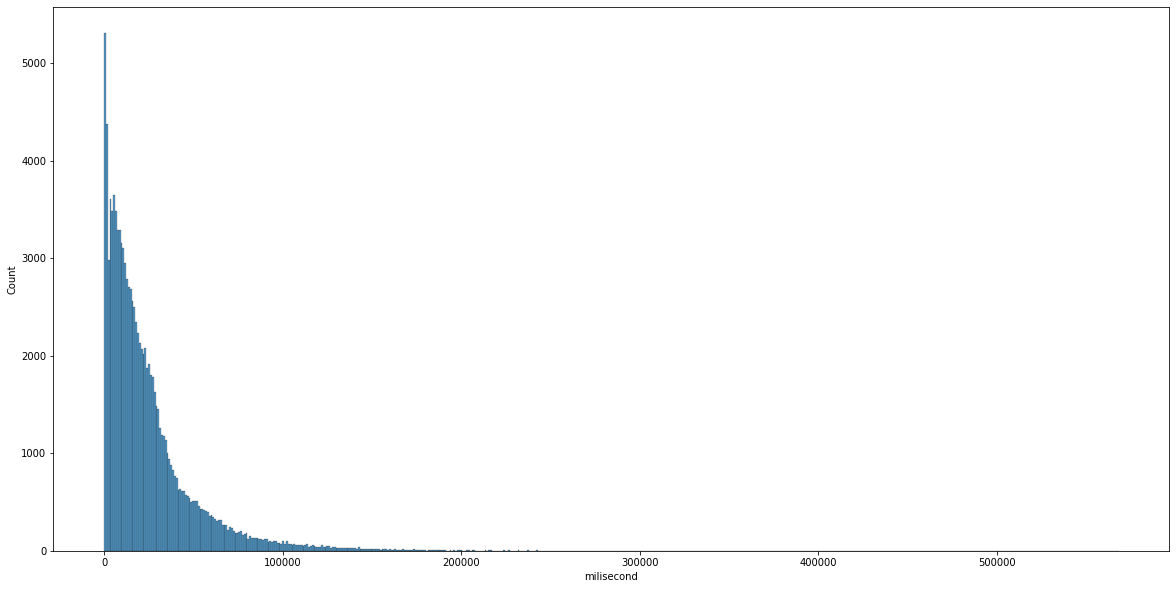

In [10]:
dMilisecond = differences['milisecond'].dropna()

plt.figure(figsize=(20,10))
sns.histplot(dMilisecond)
plt.savefig(os.path.join(imgPath, "difference_action.png"))
plt.show()

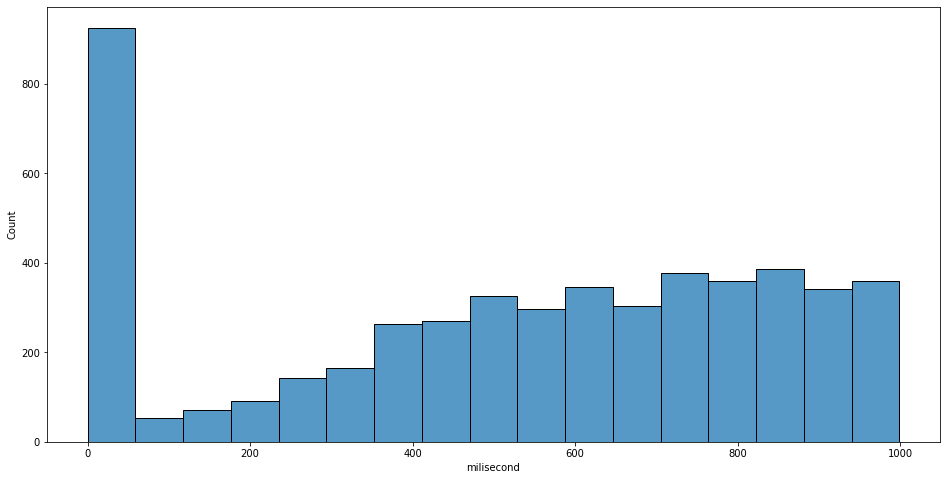

In [11]:
plt.figure(figsize=(16,8))
sns.histplot(dMilisecond[dMilisecond < 1_000])
plt.savefig(os.path.join(imgPath, "distribution_less_1.png"))
plt.show()

In [12]:
# differences[differences['milisecond'] < 1_000]
differences[(differences['milisecond']==0)]


,name,half,time,milisecond,label,team,visibility,prev
1318,england_epl/2015-2016/2015-08-08 - 19-30 Chels...,2,9:04,0.0,Shots on target,away,visible,Penalty
1519,england_epl/2015-2016/2015-08-16 - 18-00 Manch...,2,0:00,0.0,Kick-off,home,visible,Substitution
1758,england_epl/2015-2016/2015-08-23 - 15-30 West ...,2,0:22,0.0,Direct free-kick,home,visible,Shots on target
2667,england_epl/2015-2016/2015-08-30 - 18-00 Swans...,2,1:45,0.0,Indirect free-kick,home,visible,Clearance
3477,england_epl/2015-2016/2015-09-20 - 18-00 South...,2,0:00,0.0,Kick-off,away,not shown,Substitution
...,...,...,...,...,...,...,...,...
107993,spain_laliga/2016-2017/2017-04-08 - 21-45 Mala...,2,0:00,0.0,Substitution,away,not shown,Substitution
108058,spain_laliga/2016-2017/2017-04-08 - 21-45 Mala...,2,3:38,0.0,Direct free-kick,away,visible,Shots on target
109568,spain_laliga/2016-2017/2017-05-06 - 21-45 Gran...,2,0:00,0.0,Kick-off,home,not shown,Ball out of play
109571,spain_laliga/2016-2017/2017-05-06 - 21-45 Gran...,2,0:04,0.0,Ball out of play,not applicable,visible,Substitution


In [13]:
minMs = differences.groupby(by=['prev','label'])['milisecond'].min()
print(np.round(minMs))

prev              label           
Ball out of play  Ball out of play        0.0
                  Clearance             520.0
                  Corner                  0.0
                  Direct free-kick    16661.0
                  Foul                    0.0
                                       ...   
Yellow->red card  Red card              543.0
                  Shots off target    68179.0
                  Shots on target     83454.0
                  Substitution        29733.0
                  Yellow card          7027.0
Name: milisecond, Length: 223, dtype: float64


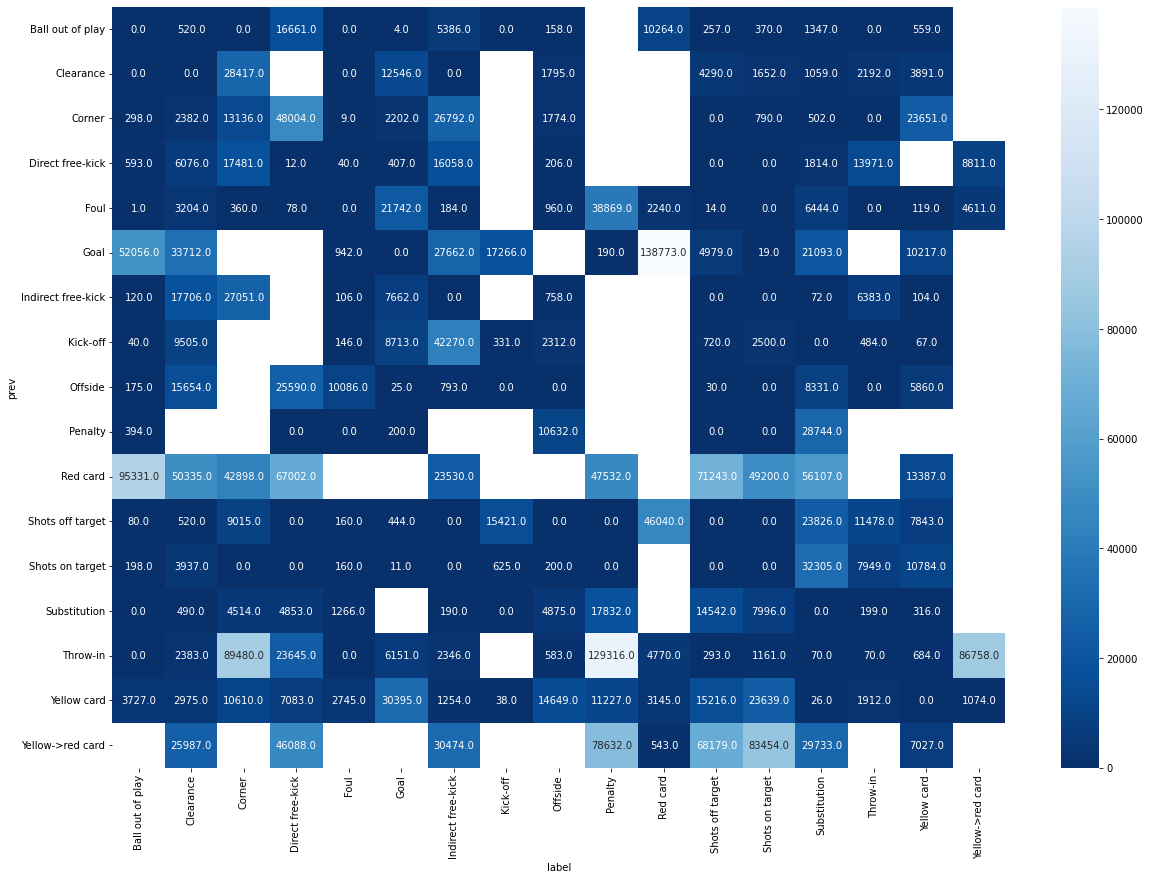

In [14]:
plt.figure(figsize=(20, 14))
minMs = differences.groupby(by=['prev','label'])['milisecond'].min()
sns.heatmap(
    data=minMs.reset_index().pivot("prev","label","milisecond"), 
    annot=True,
    fmt=".1f",
    cmap='Blues_r'
)
plt.savefig(os.path.join(imgPath, "heatmap_min.png"))
plt.show()

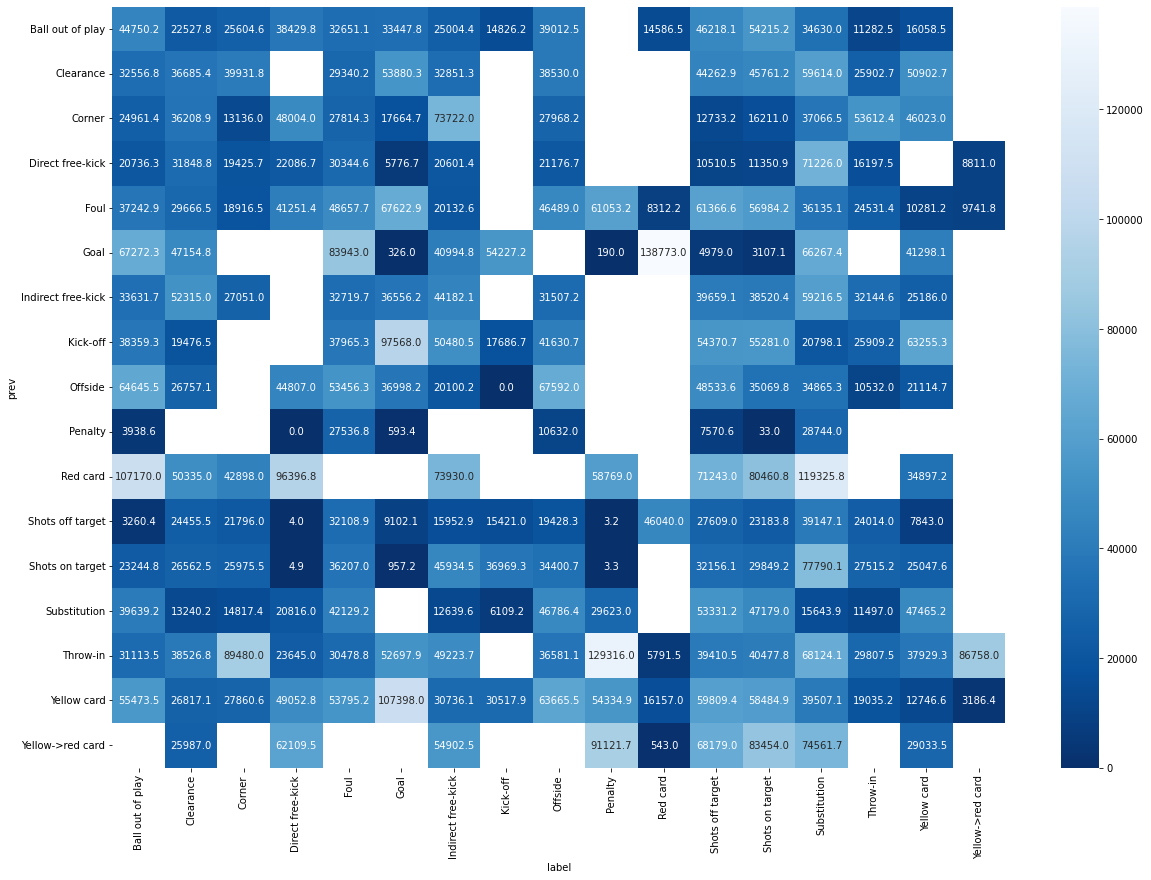

In [15]:
plt.figure(figsize=(20, 14))
meanMs = differences.groupby(by=['prev','label'])['milisecond'].mean()
sns.heatmap(
    data=meanMs.reset_index().pivot("prev","label","milisecond"), 
    annot=True,
    fmt=".1f",
    cmap='Blues_r'
)
plt.savefig(os.path.join(imgPath, "heatmap_avg.png"))
plt.show()

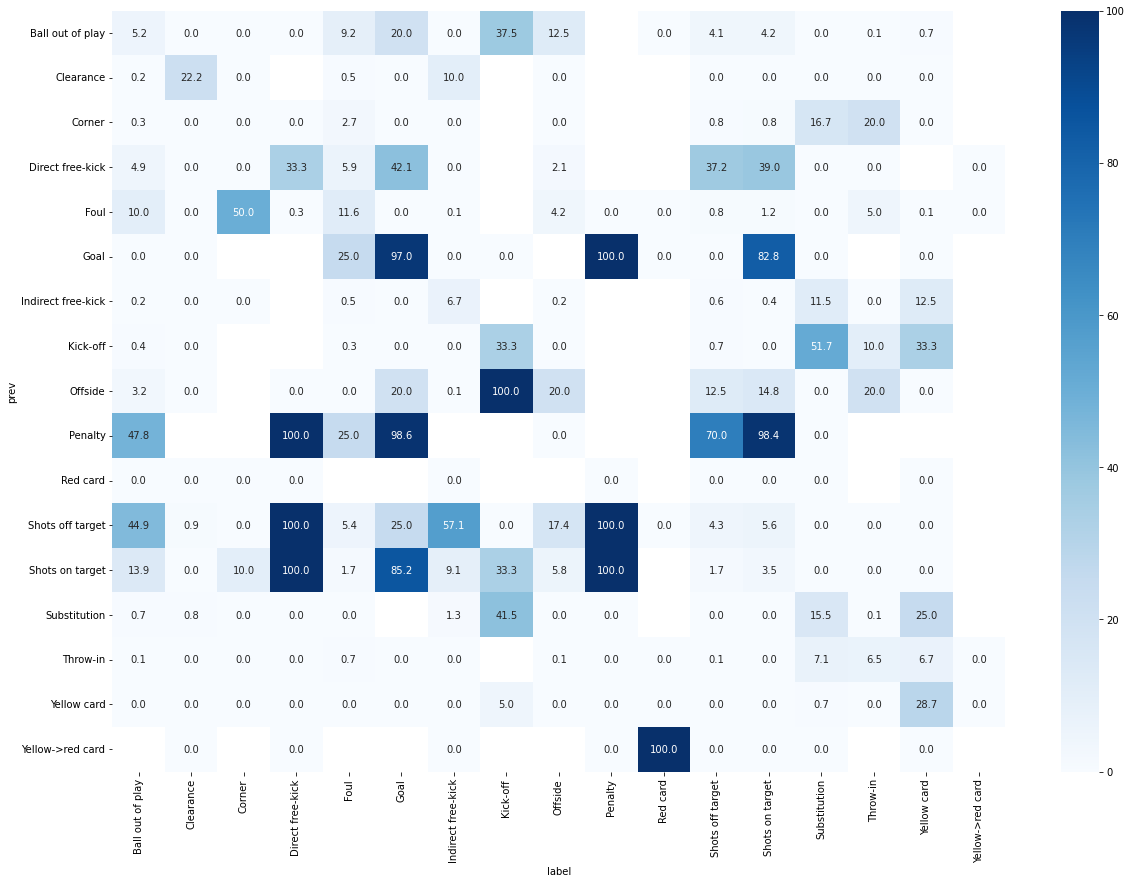

In [16]:
plt.figure(figsize=(20, 14))
groupData = differences.groupby(by=['prev','label'])['milisecond']
countAll = groupData.count()
countLess1Sec = groupData.apply(lambda x: x[x<1000].count())
sns.heatmap(
    data=(countLess1Sec/countAll*100).reset_index().pivot("prev","label","milisecond"), 
    annot=True,
    fmt=".1f",
    cmap='Blues'
)
plt.savefig(os.path.join(imgPath, "heatmap_count_less_1.png"))
plt.show()